In [20]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
import zipfile
import os

# Пути к архиву и директории
archive_path = 'C:/Users/zhara/Downloads/AML_final/archive.zip'  # Укажите путь к архиву
extract_to = 'C:/Users/zhara/Downloads/AML_final/'  # Директория для извлечения

# Извлечение архива
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Проверка наличия папки UTKFace
utkface_path = os.path.join(extract_to, 'UTKFace')
if os.path.exists(utkface_path):
    print(f"Папка UTKFace успешно извлечена в {utkface_path}")
else:
    print("Папка UTKFace не найдена в архиве.")

# Пример загрузки файлов из папки UTKFace
image_files = [os.path.join(utkface_path, f) for f in os.listdir(utkface_path) if f.endswith('.jpg')]
print(f"Найдено {len(image_files)} изображений в папке UTKFace.")


Папка UTKFace успешно извлечена в C:/Users/zhara/Downloads/AML_final/UTKFace
Найдено 23708 изображений в папке UTKFace.


In [22]:
BASE_DIR = 'C:/Users/zhara/Downloads/AML_final/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [23]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [24]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,C:/Users/zhara/Downloads/AML_final/UTKFace\20_...,20,0
1,C:/Users/zhara/Downloads/AML_final/UTKFace\35_...,35,0
2,C:/Users/zhara/Downloads/AML_final/UTKFace\36_...,36,0
3,C:/Users/zhara/Downloads/AML_final/UTKFace\1_0...,1,0
4,C:/Users/zhara/Downloads/AML_final/UTKFace\8_0...,8,0


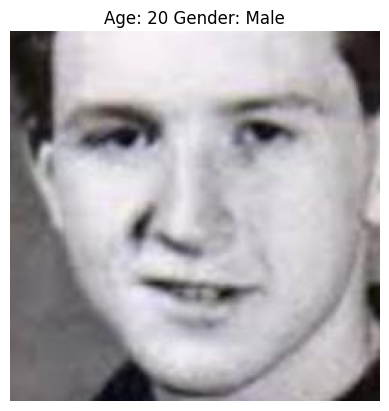

In [25]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

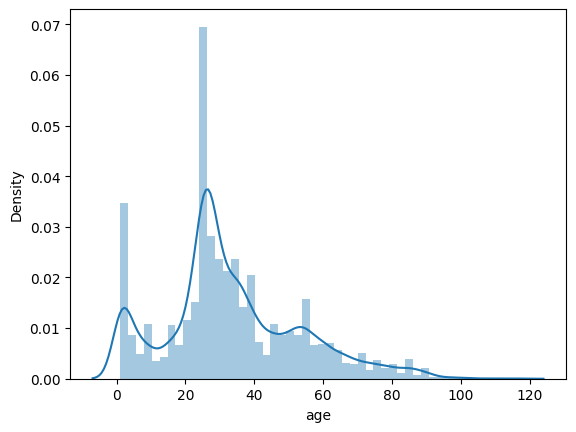

In [26]:
# Age distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['age'])
plt.show()

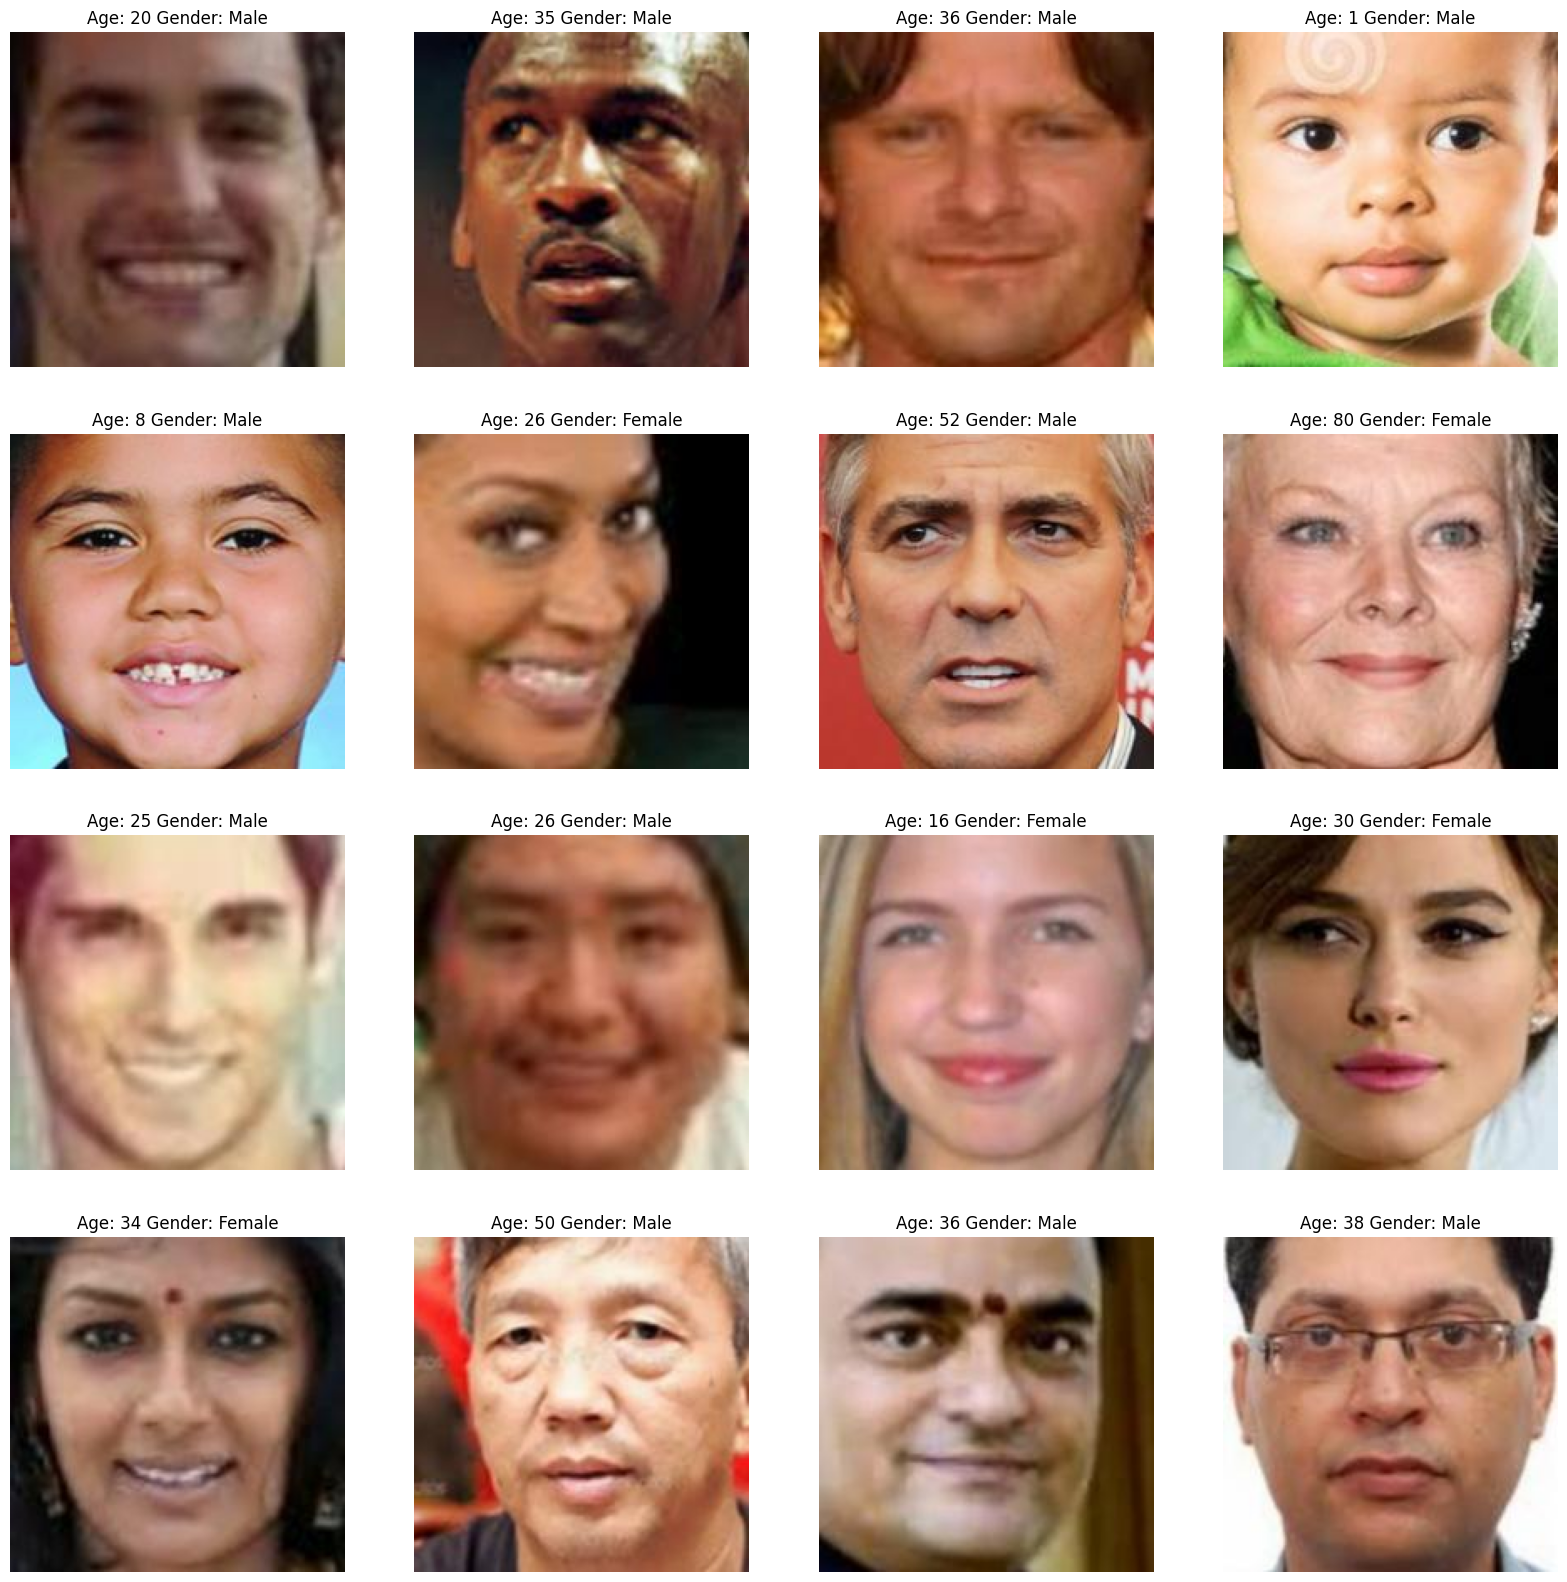

In [27]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [28]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [29]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [30]:
X.shape

(23708, 128, 128, 1)

In [31]:
X = X / 255.0

In [32]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [33]:
input_shape = (128, 128, 1)

In [34]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=[['accuracy'], ['mae']])

In [35]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [36]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - age_out_loss: 16.4570 - age_out_mae: 16.4570 - gender_out_accuracy: 0.5257 - gender_out_loss: 0.7221 - loss: 17.1791 - val_age_out_loss: 13.0301 - val_age_out_mae: 13.0471 - val_gender_out_accuracy: 0.7307 - val_gender_out_loss: 0.5519 - val_loss: 13.5985
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 105s 178ms/step - age_out_loss: 11.5717 - age_out_mae: 11.5718 - gender_out_accuracy: 0.7681 - gender_out_loss: 0.4894 - loss: 12.0612 - val_age_out_loss: 9.2129 - val_age_out_mae: 9.2109 - val_gender_out_accuracy: 0.8045 - val_gender_out_loss: 0.4159 - val_loss: 9.6251
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - age_out_loss: 9.2923 - age_out_mae: 9.2923 - gender_out_accuracy: 0.7999 - gender_out_loss: 0.4221 - loss: 9.7144 - val_age_out_loss: 8.0605 - val_age_out_mae: 8.0595 - val_gender_out_accuracy: 0.8351 - val_gender_out_loss: 0.3616 - val_loss: 8.4194
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 104s 176ms/step - age_out_l

Plot the results


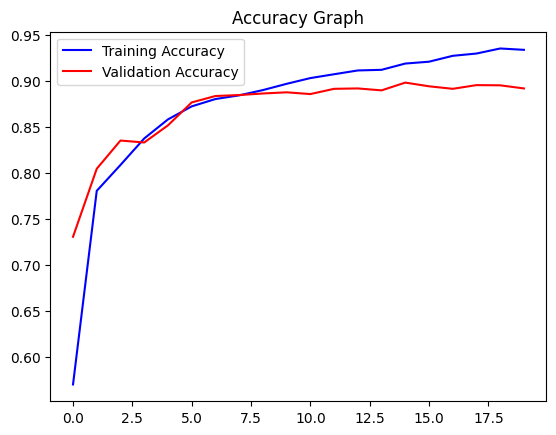

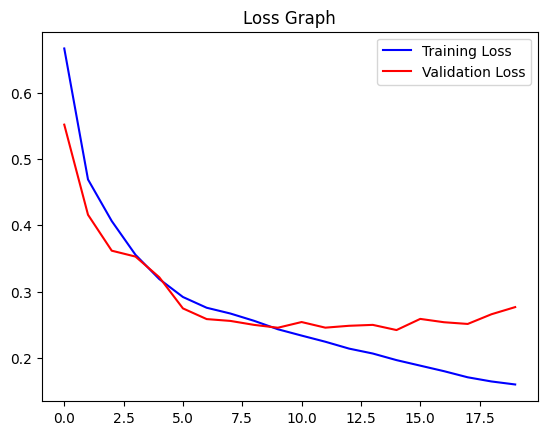

In [37]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


For age

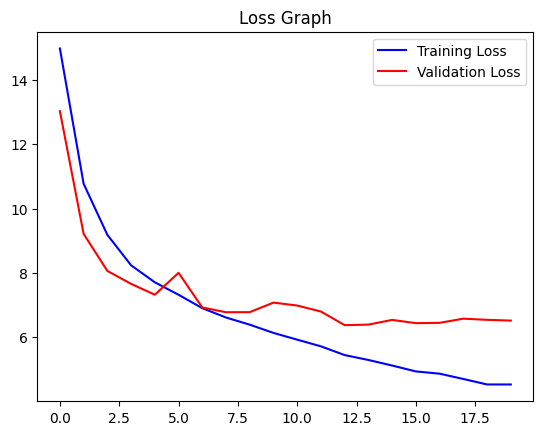

In [38]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Predicting Test Data

In [39]:
def get_image_features(image):
  img = load_img(image, color_mode='grayscale')
  img = img.resize((128, 128), Image.Resampling.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

In [40]:
img_to_test = '/content/UTKFace/21_0_4_20161223214834033.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

FileNotFoundError: [Errno 2] No such file or directory: '/content/UTKFace/21_0_4_20161223214834033.jpg.chip.jpg'